# Tutorial <span style='color:red'>?</span>: Small Angle Neutron Scattering

Small Angle Neutron Scattering (SANS) is a powerful reciprocal space technique that can be used to investigate magnetic structures on mesoscopic length scales. In SANS the atomic structure generally has a minimal impact hence the sample can be approximated by a continuous magnetisation vector field \cite{muhlbauer2019magnetic}.

The differential scattering cross section $d\Sigma/d\Omega$ can be used as a function of the scattering vector ${\bf q}$ to predict the scattering patterns produced. The scattering can be calculated with the use of the magnetic interaction vector  ${\bf Q}$ \cite{muhlbauer2019magnetic} where

\begin{equation}
    {\bf Q} = \hat{\bf q} \times \left[ \hat{\bf q} \times \widetilde{\bf M} \right],
\end{equation}
where $\hat{\bf q}$ is the unit scatering vector and $\widetilde{\bf M}$ is the Fourier transform of the magnetisation.

The scattering vector is defined as 
\begin{equation}
    {\bf q} = {\bf k}_1 - {\bf k}_0
\end{equation}
where ${\bf k}_0$ and ${\bf k}_1$ are the incident and scattered wavevectors respectively.

## SANS Reference frame

There are common scattering geometries defined in SANS, namely with a magnetic field applied to the incoming neutron beam in either a perpendicular or and parallel geometry. 

**Perpendicular geometry**: the magnetic field applied to the incoming neutron beam is along the $z$ direction while the beam propagates along the $x$ direction.
**Parallel geometry**: the magnetic field applied to the incoming neutron beam is along the $z$ direction while the beam propagates along the $z$ direction.

<span style='color:red'>Figure!!!</span>

## The micromagnetic simulation

A micromagnetic simulation can be set up using <code>Ubermag</code> to obtain a 3-Dimentional magntic structure with periodic boundary conditions in the $xy$ plane.

Field(mesh=Mesh(region=Region(p1=(-3e-07, -1.5e-07, 0.0), p2=(3e-07, 3e-07, 5e-09)), n=(120, 90, 1), bc='', subregions={}, attributes={'unit': 'm', 'fourierspace': False, 'isplane': True, 'planeaxis': 2, 'point': 2.5e-09, 'axis1': 0, 'axis2': 1}), dim=1)


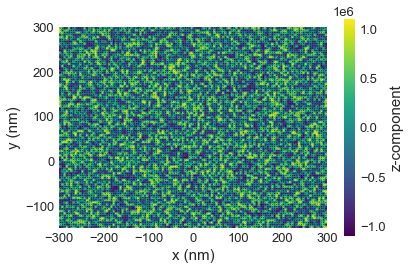

In [7]:
%matplotlib inline
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import ubermagutil.units as uu
np.random.seed(1)

region = df.Region(p1=(-300e-9, -150e-9, 0), p2=(300e-9, 300e-9, 5e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9), bc='xy')

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='T') 
                 + mm.Zeeman(H=(0, 0, 2e5)))

Ms = 1.1e6

def m_fun(pos):
    return 2 * np.random.rand(3) - 1

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_fun, norm=Ms)
system.m.plane('z').mpl.plot()

Relax the system and plot its magnetisation.

Running OOMMF (DockerOOMMFRunner) [2021/07/22 11:15]... (140.4 s)
Field(mesh=Mesh(region=Region(p1=(-3e-07, -1.5e-07, 0.0), p2=(3e-07, 3e-07, 5e-09)), n=(120, 90, 1), bc='', subregions={}, attributes={'unit': 'm', 'fourierspace': False, 'isplane': True, 'planeaxis': 2, 'point': 2.5e-09, 'axis1': 0, 'axis2': 1}), dim=1)


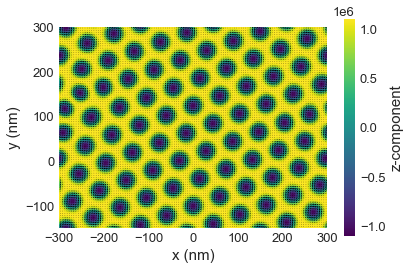

In [8]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl.plot()

Now we have a magnetisation texture we can compute the SANS patterns.

## Computing SANS Cross-sections

We can use the <code><span style='color:Red'>exsim</span></code> package to calculate the cross sections. First the geometry has to be chosen, then for this geometry the magnetic interaction vector  ${\bf Q}$ is calculated. From this the non-spin flip and spin flip cross sections can be calculated.

\begin{align}
    \frac{d\sum^{\pm \pm}}{d\Omega} &\sim |{\bf Q}_z|^2 \\
    \frac{d\sum^{\pm \mp}}{d\Omega} &\sim |{\bf Q}_x|^2 + |{\bf Q}_y|^2 \mp 
        i\left( {\bf Q}_x {\bf Q}^{\ast}_y - {\bf Q}^{\ast}_x {\bf Q}_y \right)
\end{align}

These then be combined inorder to get the half and unpolarised cross sections.

\begin{align}
    \frac{d\sum^{+}}{d\Omega} &= \frac{d\sum^{++}}{d\Omega} + \frac{d\sum^{+-}}{d\Omega} \\
    \frac{d\sum^{-}}{d\Omega} &= \frac{d\sum^{--}}{d\Omega} + \frac{d\sum^{-+}}{d\Omega} \\
    \frac{d\sum}{d\Omega} &= \frac{1}{2} \left( \frac{d\sum^{+}}{d\Omega} + \frac{d\sum^{-}}{d\Omega} \right) \\
    \frac{d\sum}{d\Omega} &= \frac{1}{2} \left( \frac{d\sum^{++}}{d\Omega} + \frac{d\sum^{+-}}{d\Omega} + 
                            \frac{d\sum^{--}}{d\Omega} + \frac{d\sum^{-+}}{d\Omega} \right)
\end{align}

For example the unpolarised cross section for the parallel scattering geometry can be calculated.

In [9]:
import exsim
import matplotlib.colors as colors
cross_section = exsim.sans.cross_section(system.m, method='unpol', geometry='parallel')

The cross section is a <code>discretisedfield</code> object the built in plotting functions can be used to view them. As the cross section is a complex quantity, to view it either the real or imaginary part has to be selected before plotting.

None


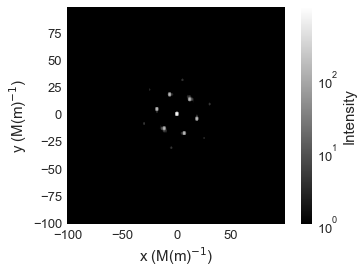

In [25]:
cross_section.real.mpl.scalar(cmap='gray', #interpolation='spline16',
                              colorbar_label=r'Intensity', norm=colors.LogNorm(vmin=1,vmax=cross_section.real.array.max()))

Field(mesh=Mesh(region=Region(p1=(-100833333.33333333, -101111111.1111111, 0.0), p2=(99166666.66666667, 98888888.88888887, 200000000.0)), n=(120, 90, 1), bc='', subregions={}, attributes={'unit': '(m)$^{-1}$', 'fourierspace': True, 'isplane': True, 'planeaxis': 2, 'point': 100000000.0, 'axis1': 0, 'axis2': 1, 'realspace_mesh': Mesh(region=Region(p1=(-3e-07, -1.5e-07, 0.0), p2=(3e-07, 3e-07, 5e-09)), n=(120, 90, 1), bc='', subregions={}, attributes={'unit': 'm', 'fourierspace': False, 'isplane': True, 'planeaxis': 2, 'point': 2.5e-09, 'axis1': 0, 'axis2': 1})}), dim=1)


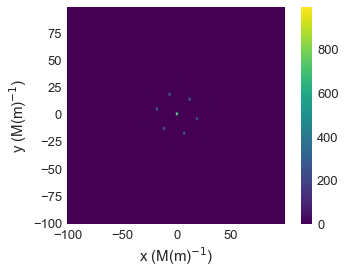

In [18]:
cross_section.real.mpl.plot()

For this set up the cross section from spin flip is

None
None


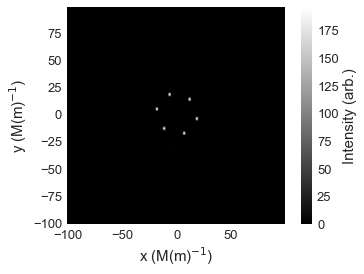

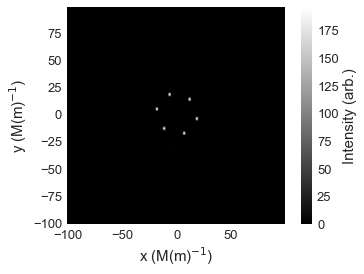

In [19]:
cross_section = exsim.sans.cross_section(system.m, method='pn', geometry='parallel')
cross_section.real.mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')
cross_section = exsim.sans.cross_section(system.m, method='np', geometry='parallel')
cross_section.real.mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')

and non-spin-flip is

None
None


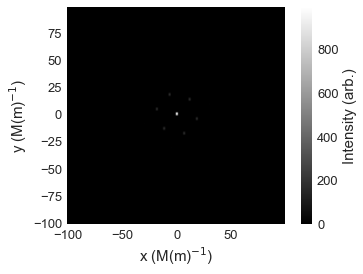

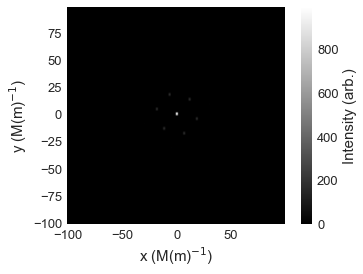

In [20]:
cross_section = exsim.sans.cross_section(system.m, method='pp', geometry='parallel')
cross_section.real.mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')
cross_section = exsim.sans.cross_section(system.m, method='nn', geometry='parallel')
cross_section.real.mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')

We can also look at the perpediular geometry. If we wish to look along the $z$ direction of the sample we will have to rotate the sample so the axes are congruent with the defitions we set i.e. rotate the samples $z$ axis to the $x$ axis as the beam is defined as traveling along the $x$ direction.

<span style='color:red'>This is silly and there should be a better way of doing this!!!</span>

In [ ]:
rot_field = df.Field()

In [69]:
def _Q_perpendicular_z_2(field):
    """
    Parameters
    ----------
    field : discretisedfield.field
        Magnetisation field.

    Returns
    -------
    discretisedfield.Field
        Magnetic interaction vector.
    """
    m_p_ft = (field * df.dz).integral(direction='z').fft2()
    theta = df.Field(m_p_ft.mesh, dim=1,
                     value=lambda x: np.arctan2(x[1], x[0]))
    Qx = (-m_p_ft.x * np.sin(theta.array)**2 +
          m_p_ft.y * np.cos(theta.array) * np.sin(theta.array))
    Qy = (-m_p_ft.y*np.cos(theta.array)**2 +
          m_p_ft.x*np.cos(theta.array)*np.sin(theta.array))
    Qz = m_p_ft.z
    return Qz << Qy << Qx

In [70]:
Q = _Q_perpendicular_z_2(system.m)

None


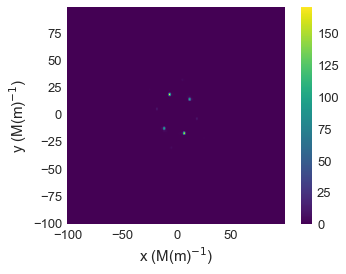

In [30]:
(Q.z * Q.z.conjugate).real.mpl.scalar()

None


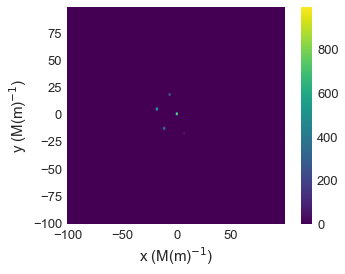

In [31]:
(Q.x*Q.x.conjugate + Q.y*Q.y.conjugate
                - 1j * (Q.x*Q.y.conjugate - Q.x.conjugate*Q.y)).real.mpl.scalar()

In [1]:
%matplotlib inline
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import ubermagutil.units as uu
import matplotlib.pyplot as plt
import exsim

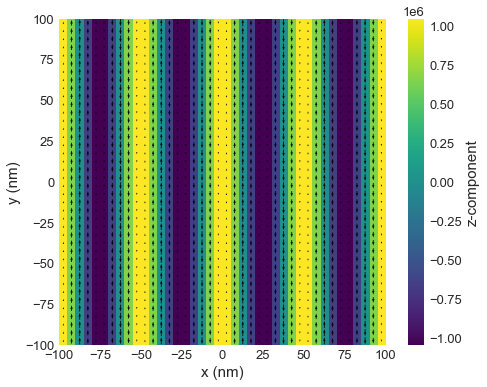

In [2]:
region = df.Region(p1=(-100e-9, -100e-9, -100e-9), p2=(100e-9, 100e-9, 100e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

Ms = 1.1e6
def m_fun2(pos):
    x, y, z =pos
    qx = 50e-9
    return (0, np.sin(2*np.pi*x/qx), np.cos(2*np.pi*x/qx))

# create system with above geometry and initial magnetisation
field = df.Field(mesh, dim=3, value=m_fun2, norm=Ms)
field.plane('z').mpl.plot()

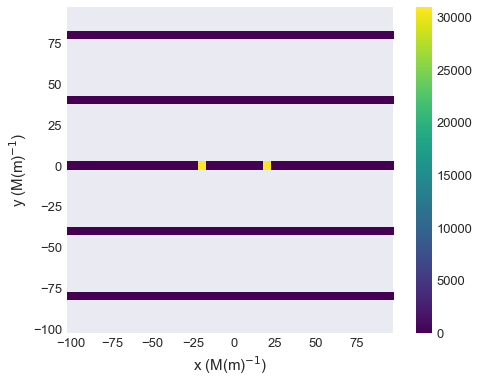

In [8]:
upol_parr = exsim.sans.cross_section(field, method='unpol', geometry='parallel')
upol_parr.real.mpl.plot()

Field(mesh=Mesh(region=Region(p1=(-2.5e-09, -1e-07, -1e-07), p2=(2.5e-09, 1e-07, 1e-07)), n=(1, 40, 40), bc='', subregions={}, attributes={'unit': 'm', 'fourierspace': False, 'isplane': True, 'planeaxis': 0, 'point': 0.0, 'axis1': 1, 'axis2': 2}), dim=1)


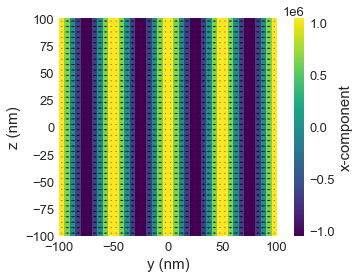

In [71]:
region = df.Region(p1=(-100e-9, -100e-9, -100e-9), p2=(100e-9, 100e-9, 100e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

Ms = 1.1e6
def m_fun2(pos):
    x, y, z =pos
    qx = 50e-9
    return (np.cos(2*np.pi*y/qx), np.sin(2*np.pi*y/qx), 0)

# create system with above geometry and initial magnetisation
field = df.Field(mesh, dim=3, value=m_fun2, norm=Ms)
field.plane('x').mpl.plot()

None


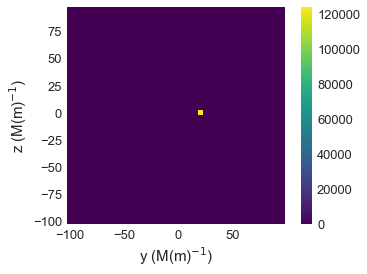

In [72]:
upol_perp = exsim.sans.cross_section(field, method='pn', geometry='perpendicular')
upol_perp.real.mpl.scalar()

Field(mesh=Mesh(region=Region(p1=(-1e-07, -1e-07, -2.5e-09), p2=(1e-07, 1e-07, 2.5e-09)), n=(40, 40, 1), bc='', subregions={}, attributes={'unit': 'm', 'fourierspace': False, 'isplane': True, 'planeaxis': 2, 'point': 0.0, 'axis1': 0, 'axis2': 1}), dim=1)


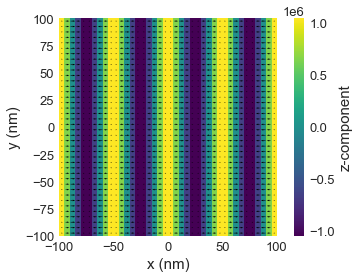

In [88]:
region = df.Region(p1=(-100e-9, -100e-9, -100e-9), p2=(100e-9, 100e-9, 100e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

Ms = 1.1e6
def m_fun2(pos):
    x, y, z =pos
    qx = 50e-9
    return (np.sin(2*np.pi*x/qx), 0, np.cos(2*np.pi*x/qx))

# create system with above geometry and initial magnetisation
field = df.Field(mesh, dim=3, value=m_fun2, norm=Ms)
field.plane('z').mpl.plot()

In [93]:
def _Q_perpendicular_z_3(field):
    """
    Parameters
    ----------
    field : discretisedfield.field
        Magneisation field.

    Returns
    -------
    discretisedfield.Field
        Magnetic interaction vector.
    """
    m_p_ft = (field * df.dz).integral(direction='z').fft2()
    theta = df.Field(m_p_ft.mesh, dim=1,
                     value=lambda x: np.arctan2(x[1], x[0]))
    Qx = -m_p_ft.z
    Qy = (m_p_ft.y*np.cos(theta.array)**2 +
          m_p_ft.x*np.cos(theta.array)*np.sin(theta.array))
    Qz = (-m_p_ft.y*np.cos(theta.array)*np.sin(theta.array) -
          m_p_ft.x*np.sin(theta.array)**2)
    return Qx << Qy << Qz

None


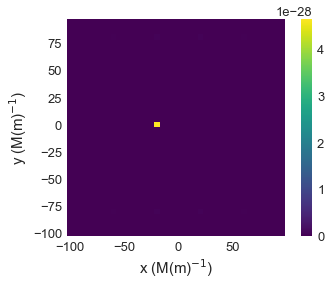

In [97]:
Q = _Q_perpendicular_z_3(field)
(Q.z*Q.z.conjugate + Q.y*Q.y.conjugate
                - 1j * (Q.z*Q.y.conjugate + Q.z.conjugate*Q.y)).real.mpl.scalar()

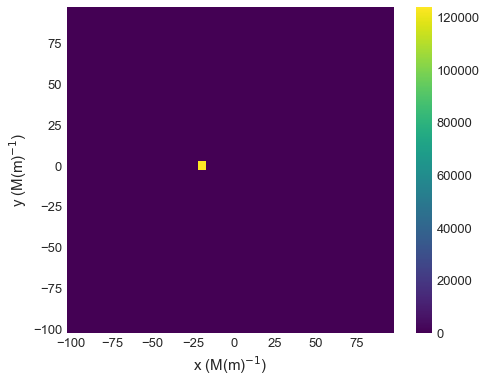

In [7]:
upol_perp = exsim.sans.cross_section(field, method='pn', geometry='perp_z_2')
upol_perp.real.mpl.scalar()

In [27]:
Q = exsim.sans._Q_perpendicular_z(field)

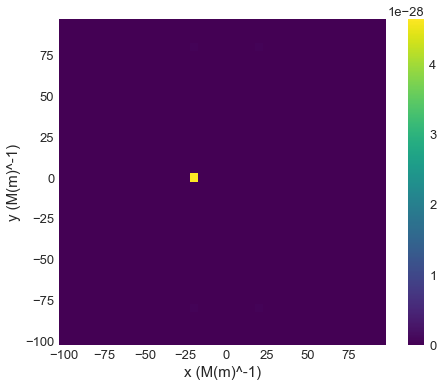

In [29]:
(Q.x * Q.x.conjugate).real.mpl()

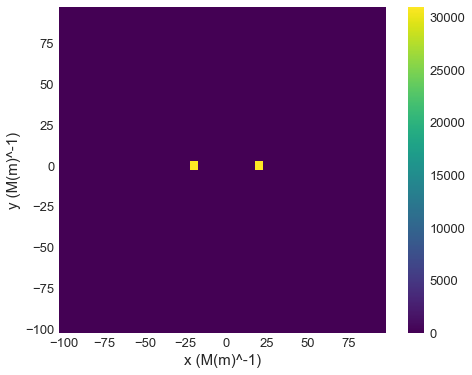

In [30]:
(Q.y*Q.y.conjugate + Q.z*Q.z.conjugate
                - 1j * (Q.y*Q.z.conjugate - Q.y.conjugate*Q.z)).real.mpl()

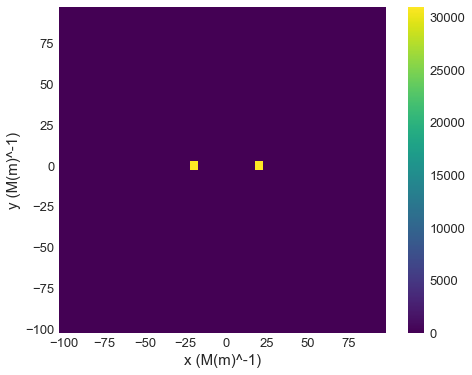

In [31]:
(Q.y*Q.y.conjugate + Q.z*Q.z.conjugate
                + 1j * (Q.y*Q.z.conjugate - Q.y.conjugate*Q.z)).real.mpl()

In [ ]:
def Q(field, beam_direction='z'):
    if beam_direction='z':
        m_p_ft = (field * df.dz).integral(direction='z').fft2()
        theta = df.Field(m_p_ft.mesh, dim=1,
                         value=lambda x: np.arctan2(x[1], x[0]))
    elif beam_direction='x'
        m_p_ft = (field * df.dx).integral(direction='x').fft2()
        theta = df.Field(m_p_ft.mesh, dim=1,
                         value=lambda x: np.arctan2(x[2], x[1]))
    elif beam_direction='y'
        m_p_ft = (field * df.dy).integral(direction='y').fft2()
        theta = df.Field(m_p_ft.mesh, dim=1,
                         value=lambda x: np.arctan2(x[0], x[2]))
    else:
        msg = f'Beam direction {beam_direction} is unknown.'
        raise ValueError(msg)

In [ ]:
    Qx = (-m_p_ft.y * np.sin(theta.array)**2 +
          m_p_ft.z * np.cos(theta.array) * np.sin(theta.array))
    Qy = (-m_p_ft.z*np.cos(theta.array)**2 +
          m_p_ft.y*np.cos(theta.array)*np.sin(theta.array))
    Qz = m_p_ft.x


\begin{align}
    {\bf Q} &= {\bf q} \times \left[ {\bf q} \times \widetilde{\bf M} \right] \\
    {\bf Q}_{\perp} &= \begin{pmatrix} 
                        -\widetilde{\bf M}_x \\
                        -\widetilde{\bf M}_y \cos^2\theta + \widetilde{\bf M}_z \sin\theta\cos\theta \\
                        \widetilde{\bf M}_y \sin\theta\cos\theta -\widetilde{\bf M}_z \sin^2\theta
                       \end{pmatrix}  \\
    {\bf Q}_{\parallel } &= \begin{pmatrix} 
                             -\widetilde{\bf M}_x \sin^2\theta + \widetilde{\bf M}_y \sin\theta\cos\theta \\
                             \widetilde{\bf M}_x \sin\theta\cos\theta - \widetilde{\bf M}_y \cos^2\theta  \\
                             -\widetilde{\bf M}_z
                            \end{pmatrix} 
\end{align}
${\bf q}$ is the unit momentum transfer vector.

\begin{align}
    \frac{d\sum^{\pm \pm}}{d\Omega} &\sim |{\bf Q}_z|^2 \\
    \frac{d\sum^{\pm \mp}}{d\Omega} &\sim |{\bf Q}_x|^2 + |{\bf Q}_y|^2 \mp 
        i\left( {\bf Q}_x {\bf Q}^{\ast}_y - {\bf Q}^{\ast}_x {\bf Q}_y \right)
\end{align}
And

\begin{align}
    \frac{d\sum^{+}}{d\Omega} &= \frac{d\sum^{++}}{d\Omega} + \frac{d\sum^{+-}}{d\Omega} \\
    \frac{d\sum^{-}}{d\Omega} &= \frac{d\sum^{--}}{d\Omega} + \frac{d\sum^{-+}}{d\Omega} \\
    \frac{d\sum}{d\Omega} &= \frac{1}{2} \left( \frac{d\sum^{+}}{d\Omega} + \frac{d\sum^{-}}{d\Omega} \right) \\
    \frac{d\sum}{d\Omega} &= \frac{1}{2} \left( \frac{d\sum^{++}}{d\Omega} + \frac{d\sum^{+-}}{d\Omega} + 
                            \frac{d\sum^{--}}{d\Omega} + \frac{d\sum^{-+}}{d\Omega} \right)
\end{align}

Choosing an experimental reference frame with the beam incoming aligned and polarised along the $z$ direction, the non-polarised SANS cross section is 
\begin{equation} \label{eq:C7:SANS}
    \frac{d\Sigma}{d\Omega} \propto \left\lVert \widetilde{M}_x \right\rVert + \left\lVert \widetilde{M}_y \right\rVert .
\end{equation}

### Importing Packages

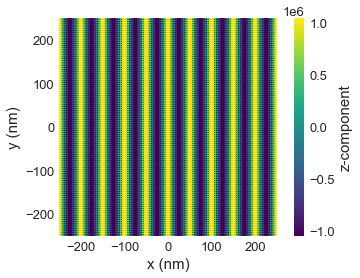

In [17]:
%matplotlib inline
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import ubermagutil.units as uu
import matplotlib.pyplot as plt

np.random.seed(1)

region = df.Region(p1=(-250e-9, -250e-9, 0), p2=(250e-9, 250e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='T') 
                 #+ mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1)) 
                 #+ mm.Demag()
                 + mm.Zeeman(H=(0, 0, 2e5)))

Ms = 1.1e6

def m_fun(pos):
    return 2 * np.random.rand(3) - 1

def m_fun2(pos):
    x, y, z =pos
    qx = 50e-9
    qy = 100e-9
    qz = 150e-9
    return (np.sin(2*np.pi*x/qx), 0, np.cos(2*np.pi*x/qx))

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_fun2, norm=Ms)
system.m.plane('z').mpl()

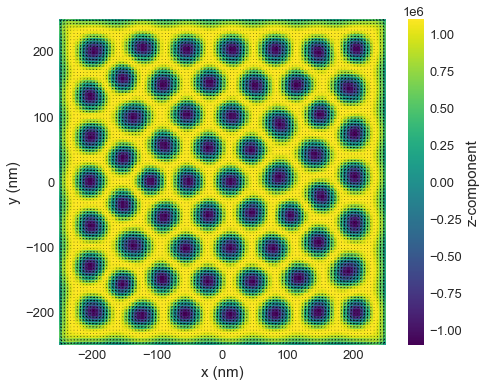

In [3]:
system.m.plane('z').mpl()

In [18]:
import exsim

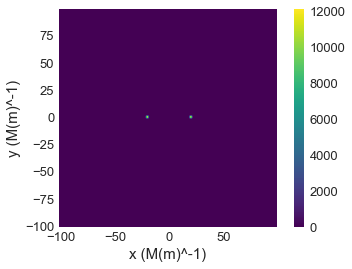

In [30]:
exsim.sans.cross_section(system.m, method='unpol', geometry='parallel').real.mpl()

In [47]:
m_p_ft = (system.m * df.dz).integral(direction='z').fft2()
theta = df.Field(m_p_ft.mesh, dim=1, value=lambda x: np.arctan2(x[1],x[0]))

q = df.Field(m_p_ft.mesh, dim=2, value=lambda x: [x[0],x[1]] / np.linalg.norm([x[0],x[1]]))

ValueError: Cannot normalise field with zero values.

In [46]:
abs((q.x*q.y).array - np.cos(theta.array)*np.sin(theta.array)).all() < 1e-5

True

In [42]:
np.cos(theta.array)*np.sin(theta.array)

array([[[[ 0.5       ]],

        [[ 0.49989798]],

        [[ 0.49958368]],

        ...,

        [[-0.49904438]],

        [[-0.49958368]],

        [[-0.49989798]]],


       [[[ 0.49989798]],

        [[ 0.5       ]],

        [[ 0.49989373]],

        ...,

        [[-0.49956616]],

        [[-0.49989373]],

        [[-0.5       ]]],


       [[[ 0.49958368]],

        [[ 0.49989373]],

        [[ 0.5       ]],

        ...,

        [[-0.49988921]],

        [[-0.5       ]],

        [[-0.49989373]]],


       ...,


       [[[-0.49904438]],

        [[-0.49956616]],

        [[-0.49988921]],

        ...,

        [[ 0.5       ]],

        [[ 0.49988921]],

        [[ 0.49956616]]],


       [[[-0.49958368]],

        [[-0.49989373]],

        [[-0.5       ]],

        ...,

        [[ 0.49988921]],

        [[ 0.5       ]],

        [[ 0.49989373]]],


       [[[-0.49989798]],

        [[-0.5       ]],

        [[-0.49989373]],

        ...,

        [[ 0.49956616]],

        

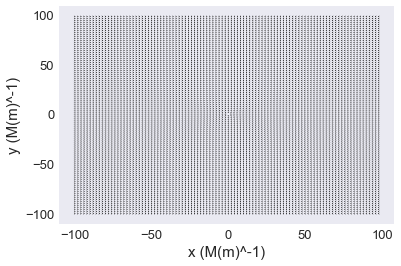

In [41]:
q.mpl_vector(use_color=False)

${\bf Q} = {\bf q} \times \left[ {\bf q} \times \widetilde{\bf M} \right]$

In [ ]:
m_fft3 = system.m.fft3().plane(z=0)
def q_val(pos):
    x, y, z = pos
    return (0, y, z)
q = df.Field(m_fft3.mesh, dim=3, value=q_val, norm=1)

In [ ]:
sv = q & (q & m_fft3)
sv = (sv * df.dz)

In [ ]:
nsf = (sv.z*sv.z.conjugate)

In [ ]:
spc1 = (sv.x*sv.x.conjugate) + (sv.y*sv.y.conjugate) - 1j * (sv.x*sv.y.conjugate - sv.x.conjugate*sv.y) 
spc2 = (sv.x*sv.x.conjugate) + (sv.y*sv.y.conjugate) + 1j * (sv.x*sv.y.conjugate - sv.x.conjugate*sv.y) 

In [ ]:
spc1.real.mpl()

In [ ]:
(spc1+spc2+nsf+nsf).real.mpl()

In [ ]:
(sv * df.dz).integral(direction='z').z.real.mpl()

In [ ]:
sv.z.plane(z=0).real.mpl()

In [ ]:
m_p_ft = (system.m * df.dz).integral(direction='z').fft2()

In [ ]:
m_p = system.m.integral(direction='z')

sans = (m_p.x.fft2()*m_p.x.fft2().conjugate + m_p.y.fft2()*m_p.y.fft2().conjugate).real

In [ ]:
sans.mpl_scalar(cmap='gray',
         interpolation='spline16',
         colorbar_label=r'Intensity (arb.)')

SANS can have other geometries and polarisation of neutrons that I am planning to add. I just need to get my head around the differnt geometries.

\begin{align}
    {\bf Q} &= {\bf q} \times \left[ {\bf q} \times \widetilde{\bf M} \right] \\
    {\bf Q}_{\perp} &= \begin{pmatrix} 
                        -\widetilde{\bf M}_x \\
                        -\widetilde{\bf M}_y \cos^2\theta + \widetilde{\bf M}_z \sin\theta\cos\theta \\
                        \widetilde{\bf M}_y \sin\theta\cos\theta -\widetilde{\bf M}_z \sin2\theta
                       \end{pmatrix}  \\
    {\bf Q}_{\parallel } &= \begin{pmatrix} 
                             -\widetilde{\bf M}_x \sin^2\theta + \widetilde{\bf M}_y \sin\theta\cos\theta \\
                             \widetilde{\bf M}_x \sin\theta\cos\theta - \widetilde{\bf M}_y \cos^2\theta  \\
                             -\widetilde{\bf M}_z
                            \end{pmatrix} 
\end{align}
${\bf q}$ is the unit momentum transfer vector.

\begin{align}
    \frac{d\sum^{\pm \pm}}{d\Omega} &\sim |{\bf Q}_z|^2 \\
    \frac{d\sum^{\pm \mp}}{d\Omega} &\sim |{\bf Q}_x|^2 + |{\bf Q}_y|^2 \mp 
        i\left( {\bf Q}_x {\bf Q}^{\ast}_y - {\bf Q}^{\ast}_x {\bf Q}_y \right)
\end{align}
And

\begin{align}
    \frac{d\sum^{+}}{d\Omega} &= \frac{d\sum^{++}}{d\Omega} + \frac{d\sum^{+-}}{d\Omega} \\
    \frac{d\sum^{-}}{d\Omega} &= \frac{d\sum^{--}}{d\Omega} + \frac{d\sum^{-+}}{d\Omega} \\
    \frac{d\sum}{d\Omega} &= \frac{1}{2} \left( \frac{d\sum^{+}}{d\Omega} + \frac{d\sum^{-}}{d\Omega} \right) \\
    \frac{d\sum}{d\Omega} &= \frac{1}{2} \left( \frac{d\sum^{++}}{d\Omega} + \frac{d\sum^{+-}}{d\Omega} + 
                            \frac{d\sum^{--}}{d\Omega} + \frac{d\sum^{-+}}{d\Omega} \right)
\end{align}

In [ ]:
import exsim

In [ ]:
sans1 = exsim.sans.cross_section(system.m, method='unpolarised', geometry='perpendicular')

In [ ]:
sans2 = exsim.sans.cross_section(system.m, method='unpol', geometry='perpendicular')
fig, ax = plt.subplots(figsize=(8,8))
sans2.real.mpl_scalar(ax=ax, cmap='gray',
         interpolation='spline16',
         colorbar_label=r'Intensity (arb.)')

In [ ]:
kx=ky=0.1
m_p_ft = (system.m * df.dz).integral(direction='z').fft2()
k = df.Field(m_p_ft.mesh, dim=3, value=lambda x: x)
denom = (k.x**2 + k.y**2) / (k.x**2 + k.y**2
                                 + k.mesh.dx**2*kx**2 + k.mesh.dy**2*ky**2)**2
theta = np.arctan2(k.y.array.squeeze(), k.x.array.squeeze())

In [ ]:
plt.imshow(theta.T, origin='lower')
plt.colorbar()

In [ ]:
theta = theta[...,np.newaxis,np.newaxis]

In [ ]:
volume = system.m.mesh.region.edges[0]*system.m.mesh.region.edges[1]*system.m.mesh.region.edges[2]

In [ ]:
volume

In [ ]:
b_H = 2.91e8 
K = 8 * np.pi**3 * b_H**2 / volume

In [ ]:
K

In [ ]:
def sans_polarised_pp(Q):
    return Q.z*Q.z.conjugate

def sans_polarised_nn(Q):
    return Q.z*Q.z.conjugate

def sans_polarised_pn(Q):
    return (Q.x*Q.x.conjugate + Q.y*Q.y.conjugate - 1j * (Q.x*Q.y.conjugate - Q.x.conjugate*Q.y))

def sans_polarised_np(Q):
    return (Q.x*Q.x.conjugate + Q.y*Q.y.conjugate + 1j * (Q.x*Q.y.conjugate - Q.x.conjugate*Q.y))

def sans_half_polarised_p(Q):
    return sans_polarised_pp(Q) + sans_polarised_pn(Q)

def sans_half_polarised_n(Q):
    return sans_polarised_nn(Q) + sans_polarised_np(Q)

def sans_unpolarised(Q):
    return 0.5*(sans_half_polarised_p(Q) + sans_half_polarised_n(Q))

def chiral_function(Q):
    return (sans_polarised_pn(Q) - sans_polarised_np(Q)) / (-2 * 1j)

In [ ]:
Q_perp = (-m_p_ft.x << 
              -m_p_ft.y*np.cos(theta)**2 + m_p_ft.z*np.cos(theta)*np.sin(theta) << 
               m_p_ft.y*np.cos(theta)*np.sin(theta) - m_p_ft.z*np.sin(theta)**2)

In [ ]:
sans1 = K*sans_unpolarised(Q_perp)
sans1.real.mpl_scalar(cmap='gray',
         interpolation='spline16',
         colorbar_label=r'Intensity (arb.)')

In [ ]:
system.m.integral(direction='z').mpl()

In [ ]:
(system.m * df.dz).integral(direction='z').mpl()

In [ ]:
def sans_Q_perp(field, theta):
    m_p_ft = field.integral(direction='z').fft2()
    Q_perp = (-m_p_ft.x << 
              -m_p_ft.y*np.cos(theta)**2 + m_p_ft.z*np.cos(theta)*np.sin(theta) << 
               m_p_ft.y*np.cos(theta)*np.sin(theta) - m_p_ft.z*np.sin(theta)**2)
    return Q_perp

def sans_Q_parallel(field, theta):
    m_p_ft = field.integral(direction='z').fft2()
    Q_parallel = (-m_p_ft.x*np.sin(theta)**2 + m_p_ft.y*np.cos(theta)*np.sin(theta) << 
                  -m_p_ft.y*np.cos(theta)**2 + m_p_ft.x*np.cos(theta)*np.sin(theta) << 
                  m_p_ft.z)
    return Q_parallel

def sans_polarised_pp(Q):
    return Q.z*Q.z.conjugate

def sans_polarised_nn(Q):
    return Q.z*Q.z.conjugate

def sans_polarised_pn(Q):
    return (Q.x*Q.x.conjugate + Q.y*Q.y.conjugate - 1j * (Q.x*Q.y.conjugate - Q.x.conjugate*Q.y))

def sans_polarised_np(Q):
    return (Q.x*Q.x.conjugate + Q.y*Q.y.conjugate + 1j * (Q.x*Q.y.conjugate - Q.x.conjugate*Q.y))

def sans_half_polarised_p(Q):
    return sans_polarised_pp(Q) + sans_polarised_pn(Q)

def sans_half_polarised_n(Q):
    return sans_polarised_nn(Q) + sans_polarised_np(Q)

def sans_unpolarised(Q):
    return 0.5*(sans_half_polarised_p(Q) + sans_half_polarised_n(Q))

def chiral_function(Q):
    return (sans_polarised_pn(Q) - sans_polarised_np(Q)) / (-2 * 1j)

In [ ]:
cf = exsim.sans.chiral_function(system.m, geometry='parallel', theta=np.pi/2)
cf.imag.mpl_scalar()

In [ ]:
theta = 0
m_p_ft = m_p.fft2()
chiral_f = (m_p_ft.x*m_p_ft.y.conjugate - m_p_ft.x.conjugate*m_p_ft.y) * np.cos(theta)**2
chiral_f += -(m_p_ft.x*m_p_ft.z.conjugate - m_p_ft.x.conjugate*m_p_ft.z) * np.cos(theta) * np.sin(theta)

chiral_f.imag.mpl_scalar()

In [ ]:
cf2a = exsim.sans.cross_section(system.m, method='pn', geometry='perpendicular')
cf2b = exsim.sans.cross_section(system.m, method='np', geometry='perpendicular')
cf2 = (cf2a-cf2b)/(-2 *1j)
cf2.imag.mpl_scalar()

In [ ]:
Q = exsim.sans.magnetic_interaction_vector(system.m, geometry='perpendicular')

In [ ]:
sans1.real.mpl_scalar()

In [ ]:
theta = 0#np.pi/2
Q = sans_Q_perp(system.m, theta)
sans_unpolarised(Q).real.mpl_scalar()

In [ ]:
sans_polarised_pp(system.m, theta, geometry='perp')

In [ ]:
theta = 0#p.pi/2

m_p_ft = m_p.fft2()
Q_perp = (-m_p_ft.x << 
          -m_p_ft.y*np.cos(theta)**2 + m_p_ft.z*np.cos(theta)*np.sin(theta) << 
          m_p_ft.y*np.cos(theta)*np.sin(theta) - m_p_ft.z*np.sin(theta)**2)

Q_para = (-m_p_ft.x*np.sin(theta)**2 + m_p_ft.y*np.cos(theta)*np.sin(theta) << 
          -m_p_ft.y*np.cos(theta)**2 + m_p_ft.x*np.cos(theta)*np.sin(theta) << 
          m_p_ft.z)

In [ ]:
cross_perp_pp = Q_perp.z*Q_perp.z.conjugate
cross_perp_nn = Q_perp.z*Q_perp.z.conjugate
cross_perp_pn = (Q_perp.x*Q_perp.x.conjugate + Q_perp.y*Q_perp.y.conjugate + 
            1j * (Q_perp.x*Q_perp.y.conjugate - Q_perp.x.conjugate*Q_perp.y))
cross_perp_np = (Q_perp.x*Q_perp.x.conjugate + Q_perp.y*Q_perp.y.conjugate - 
            1j * (Q_perp.x*Q_perp.y.conjugate - Q_perp.x.conjugate*Q_perp.y))

In [ ]:
p=1/2
sf=1
cross_perp_sanspol = (cross_perp_pp +
                      Q_perp.x*Q_perp.x.conjugate + Q_perp.y*Q_perp.y.conjugate + 
                      1j * (Q_perp.x*Q_perp.y.conjugate - Q_perp.x.conjugate*Q_perp.y) *
                      (2*p-1) * (2*sf-1))

In [ ]:
cross_perp_sanspol.real.mpl()

In [ ]:
cross_perp_pn.real.mpl()

In [ ]:
t_sans = 0.5 * (cross_pp + cross_pn + cross_np + cross_nn)

In [ ]:
t_sans.real.mpl_scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')

In [ ]:
(cross_perp_pn-cross_perp_np).real.mpl_scalar()

In [ ]:
((t_sans-sans)/sans).real.mpl()

In [ ]:
cross_perp_pp.real.mpl()